In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [15]:
%cd /content/drive/MyDrive
!unzip archive.zip -d dataEmotion

Streaming output truncated to the last 5000 lines.
  inflating: dataEmotion/archive/train/sad/Training_10094936.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10115766.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10235859.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10444028.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10576214.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10643239.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10665136.jpg  
  inflating: dataEmotion/archive/train/sad/Training_10842325.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11106902.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11112803.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11213631.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11324743.jpg  
  inflating: dataEmotion/archive/train/sad/Training_1143303.jpg  
  inflating: dataEmotion/archive/train/sad/Training_11527959.jpg  
  inflating:

In [16]:

# declare path
train_dir = '/content/drive/MyDrive/dataEmotion/archive/train/'
test_dir = '/content/drive/MyDrive/dataEmotion/archive/test/'

# Image size

IMAGE_SIZE = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 100
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']



In [17]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)



In [18]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)



Found 30889 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [19]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

,angry,disgust,fear,happy,neutral,sad,surprise
train,3995,2616,4097,7215,4965,4830,3171
test,958,111,1024,1774,1233,1247,831


In [20]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [21]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


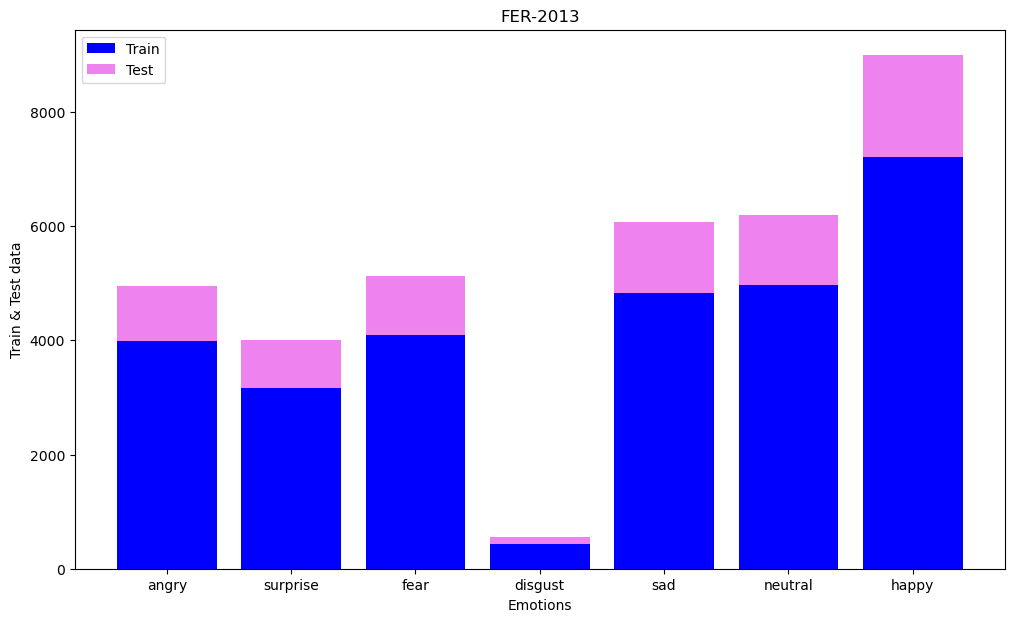

In [ ]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='blue')
plt.bar(x, y2, bottom=y1, color='violet')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

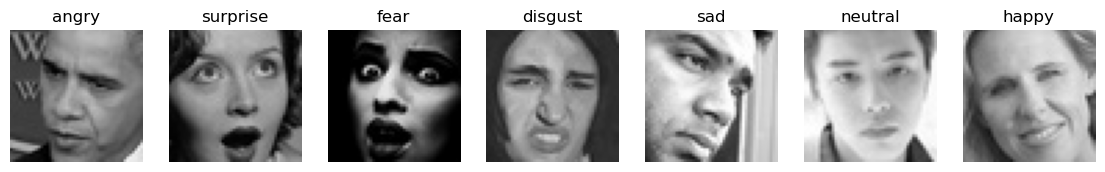

In [ ]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [9]:
# VGG16

base_model = tf.keras.applications.VGG16(input_shape= IMAGE_SHAPE,include_top=False,weights="imagenet")
base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

In [10]:
# Freezing Layers

for layer in base_model.layers[:11]:
    layer.trainable=False


In [11]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GaussianNoise(0.01))
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 batch_normalization (BatchN  (None, 1, 1, 512)        2048      
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 1, 1, 512)        0         
 se)                                                             
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                        

In [ ]:
# # Compile model

# def f1_score(y_true, y_pred): #taken from old keras source code
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     recall = true_positives / (possible_positives + K.epsilon())
#     f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
#     return f1_val

# METRICS = [
#       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
#       tf.keras.metrics.Precision(name='precision'),
#       tf.keras.metrics.Recall(name='recall'),  
#       tf.keras.metrics.AUC(name='auc'),
#       f1_score,
# ]

# adam = tf.keras.optimizers.legacy.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [25]:
checkpoint = ModelCheckpoint("./modelVGG.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [checkpoint,reduce_learningrate]

epochs = 30

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [26]:
counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

# lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
# mcp = ModelCheckpoint('modelVGG.h5')
# es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = 20,
                  verbose =1,
                  callbacks = callbacks_list, 
                  class_weight = class_weights)

Epoch 1/20
483/483 [==============================] - ETA: 0s - loss: 2.4050 - accuracy: 0.4592

483/483 [==============================] - 128s 257ms/step - loss: 2.4050 - accuracy: 0.4592 - val_loss: 1.4072 - val_accuracy: 0.4806 - lr: 0.0010
Epoch 2/20
483/483 [==============================] - ETA: 0s - loss: 2.3498 - accuracy: 0.4736

483/483 [==============================] - 124s 257ms/step - loss: 2.3498 - accuracy: 0.4736 - val_loss: 1.5841 - val_accuracy: 0.4256 - lr: 0.0010
Epoch 3/20
483/483 [==============================] - ETA: 0s - loss: 2.2981 - accuracy: 0.4825

483/483 [==============================] - 122s 253ms/step - loss: 2.2981 - accuracy: 0.4825 - val_loss: 1.3383 - val_accuracy: 0.4971 - lr: 0.0010
Epoch 4/20
483/483 [==============================] - ETA: 0s - loss: 2.2614 - accuracy: 0.4970

483/483 [==============================] - 121s 250ms/step - loss: 2.2614 - accuracy: 0.4970 - val_loss: 1.3564 - val_accuracy: 0.5205 - lr: 0.0010
Epoch 5/20
483/483 [==============================] - ETA: 0s - loss: 2.2143 - accuracy: 0.5060

483/483 [==============================] - 129s 267ms/step - loss: 2.2143 - accuracy: 0.5060 - val_loss: 1.2480 - val_accuracy: 0.5543 - lr: 0.0010
Epoch 6/20
483/483 [==============================] - ETA: 0s - loss: 2.1833 - accuracy: 0.5169

483/483 [==============================] - 121s 251ms/step - loss: 2.1833 - accuracy: 0.5169 - val_loss: 1.3415 - val_accuracy: 0.5355 - lr: 0.0010
Epoch 7/20
483/483 [==============================] - ETA: 0s - loss: 2.1574 - accuracy: 0.5218

483/483 [==============================] - 128s 266ms/step - loss: 2.1574 - accuracy: 0.5218 - val_loss: 1.2816 - val_accuracy: 0.5240 - lr: 0.0010
Epoch 8/20
483/483 [==============================] - ETA: 0s - loss: 2.1261 - accuracy: 0.5290

483/483 [==============================] - 121s 251ms/step - loss: 2.1261 - accuracy: 0.5290 - val_loss: 1.2157 - val_accuracy: 0.5737 - lr: 0.0010
Epoch 9/20
483/483 [==============================] - ETA: 0s - loss: 2.0730 - accuracy: 0.5437

483/483 [==============================] - 128s 265ms/step - loss: 2.0730 - accuracy: 0.5437 - val_loss: 1.3273 - val_accuracy: 0.5043 - lr: 0.0010
Epoch 10/20
483/483 [==============================] - ETA: 0s - loss: 2.0503 - accuracy: 0.5456

483/483 [==============================] - 142s 293ms/step - loss: 2.0503 - accuracy: 0.5456 - val_loss: 1.3699 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 11/20
483/483 [==============================] - ETA: 0s - loss: 2.0291 - accuracy: 0.5536


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
483/483 [==============================] - 125s 259ms/step - loss: 2.0291 - accuracy: 0.5536 - val_loss: 1.2384 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 12/20
483/483 [==============================] - ETA: 0s - loss: 1.9100 - accuracy: 0.5753

483/483 [==============================] - 127s 263ms/step - loss: 1.9100 - accuracy: 0.5753 - val_loss: 1.1404 - val_accuracy: 0.5936 - lr: 2.0000e-04
Epoch 13/20
483/483 [==============================] - ETA: 0s - loss: 1.8636 - accuracy: 0.5905

483/483 [==============================] - 120s 249ms/step - loss: 1.8636 - accuracy: 0.5905 - val_loss: 1.1155 - val_accuracy: 0.6021 - lr: 2.0000e-04
Epoch 14/20
483/483 [==============================] - ETA: 0s - loss: 1.8386 - accuracy: 0.5918

483/483 [==============================] - 122s 253ms/step - loss: 1.8386 - accuracy: 0.5918 - val_loss: 1.2004 - val_accuracy: 0.5748 - lr: 2.0000e-04
Epoch 15/20
483/483 [==============================] - ETA: 0s - loss: 1.8217 - accuracy: 0.5960

483/483 [==============================] - 119s 247ms/step - loss: 1.8217 - accuracy: 0.5960 - val_loss: 1.1105 - val_accuracy: 0.6025 - lr: 2.0000e-04
Epoch 16/20
483/483 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.5965

483/483 [==============================] - 122s 253ms/step - loss: 1.8128 - accuracy: 0.5965 - val_loss: 1.1497 - val_accuracy: 0.5809 - lr: 2.0000e-04
Epoch 17/20
483/483 [==============================] - ETA: 0s - loss: 1.7953 - accuracy: 0.6005

483/483 [==============================] - 122s 253ms/step - loss: 1.7953 - accuracy: 0.6005 - val_loss: 1.1381 - val_accuracy: 0.5985 - lr: 2.0000e-04
Epoch 18/20
483/483 [==============================] - ETA: 0s - loss: 1.7687 - accuracy: 0.6052


Epoch 18: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
483/483 [==============================] - 122s 252ms/step - loss: 1.7687 - accuracy: 0.6052 - val_loss: 1.1327 - val_accuracy: 0.5967 - lr: 2.0000e-04
Epoch 19/20
483/483 [==============================] - ETA: 0s - loss: 1.7294 - accuracy: 0.6144

483/483 [==============================] - 120s 249ms/step - loss: 1.7294 - accuracy: 0.6144 - val_loss: 1.1704 - val_accuracy: 0.6017 - lr: 4.0000e-05
Epoch 20/20
483/483 [==============================] - ETA: 0s - loss: 1.7218 - accuracy: 0.6164

483/483 [==============================] - 118s 244ms/step - loss: 1.7218 - accuracy: 0.6164 - val_loss: 1.1039 - val_accuracy: 0.5963 - lr: 4.0000e-05


In [27]:
model.save('modelVgg16_au.h5') 

In [28]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    

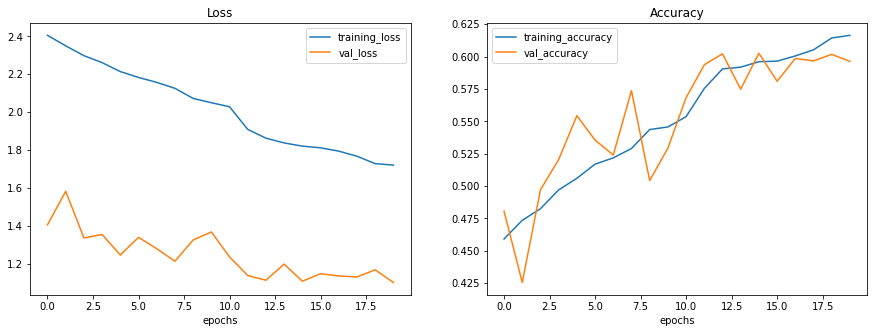

In [29]:
plot_curves(history)

In [34]:
Vgg16_Predictions = model.predict(test_dataset)

# Choosing highest probalbilty class in every prediction 
Vgg16_Predictions = np.argmax(Vgg16_Predictions, axis=1)



113/113 [==============================] - 35s 310ms/step


In [33]:
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'historyResnetBase_au.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

<Figure size 432x288 with 0 Axes>

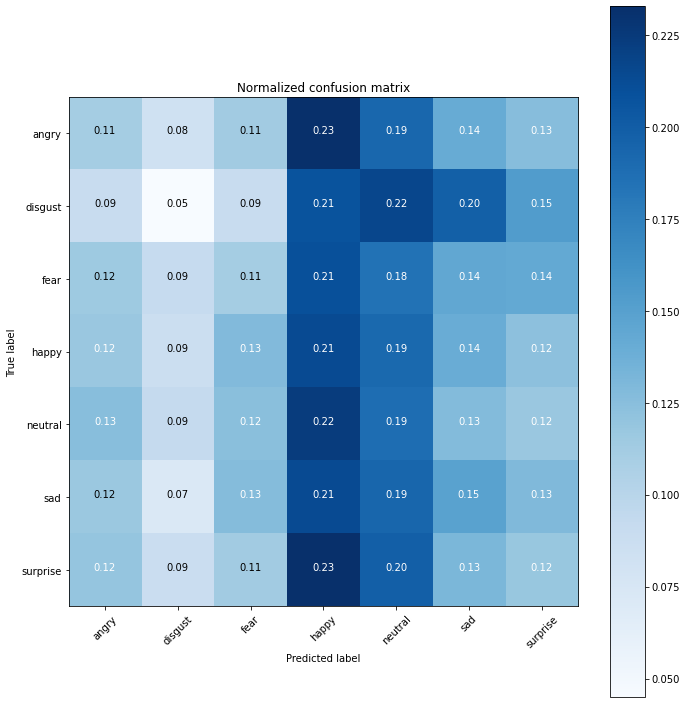

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(test_dataset.labels, Vgg16_Predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_dataset.class_indices.keys(), title='Normalized confusion matrix')
plt.show()



In [36]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(48,48,3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

ResNet50V2.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 26, 26, 64)   0           ['conv1_conv[0][0]']             
                        

In [37]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False



In [38]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model



In [39]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 dropout_2 (Dropout)         (None, 2, 2, 2048)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 2, 2, 2048)       8192      
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                524352    
                                                                 
 batch_normalization_4 (Batc  (None, 64)               256       
 hNormalization)                                      

In [40]:
batch_size = 64

In [41]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_dataset.n // train_dataset.batch_size
validation_steps = test_dataset.n // test_dataset.batch_size

In [42]:
ResNet50V2_history = ResNet50V2_Model.fit(train_dataset ,validation_data = test_dataset , epochs=30, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/30
482/482 [==============================] - 137s 256ms/step - loss: 1.9885 - accuracy: 0.3056 - val_loss: 2.1709 - val_accuracy: 0.3751 - lr: 0.0010
Epoch 2/30
482/482 [==============================] - 122s 253ms/step - loss: 1.7074 - accuracy: 0.3845 - val_loss: 1.4396 - val_accuracy: 0.4713 - lr: 0.0010
Epoch 3/30
482/482 [==============================] - 128s 265ms/step - loss: 1.6027 - accuracy: 0.4093 - val_loss: 2.2495 - val_accuracy: 0.4655 - lr: 0.0010
Epoch 4/30
482/482 [==============================] - 129s 268ms/step - loss: 1.5761 - accuracy: 0.4177 - val_loss: 1.4323 - val_accuracy: 0.4761 - lr: 0.0010
Epoch 5/30
482/482 [==============================] - 122s 253ms/step - loss: 1.5450 - accuracy: 0.4295 - val_loss: 1.4309 - val_accuracy: 0.4777 - lr: 0.0010
Epoch 6/30
482/482 [==============================] - 129s 268ms/step - loss: 1.5066 - accuracy: 0.4423 - val_loss: 1.3925 - val_accuracy: 0.4944 - lr: 0.0010
Epoch 7/30
482/482 [==========================

In [43]:
ResNet50V2_Model.save('modelResNet50V2_au.h5') 

In [49]:
%cd /content/drive/MyDrive
import pandas as pd


# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(ResNet50V2_history.history) 

# or save to csv: 
hist_csv_file = 'ResNet50V2_history_au.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

/content/drive/MyDrive


In [44]:
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()
    

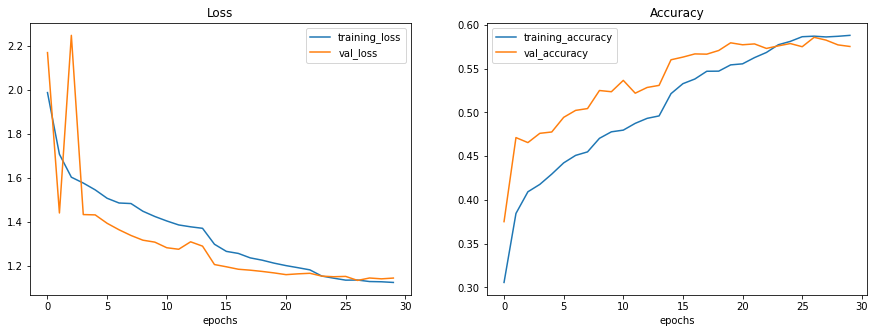

In [45]:
plot_curves(ResNet50V2_history)

In [46]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_dataset)

# Choosing highest probalbilty class in every prediction 
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)



113/113 [==============================] - 37s 320ms/step


<Figure size 432x288 with 0 Axes>

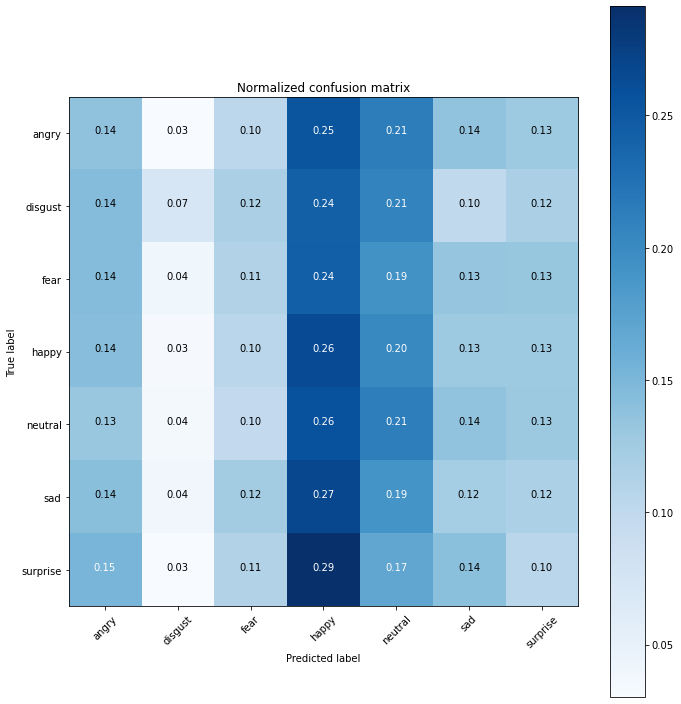

In [47]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(test_dataset.labels, ResNet50V2_Predictions)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=test_dataset.class_indices.keys(), title='Normalized confusion matrix')
plt.show()

